In [2]:
# Configuration - Change sample number here
SAMPLE_NUMBER = "1"  

# Auto-generate paths based on sample number
BASE_DIR = f"/Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/{SAMPLE_NUMBER}"
ROI_DIR = f"{BASE_DIR}/cell_rois"
RAW_CROPS_DIR = f"{BASE_DIR}/raw_crops"

print(f"Processing Sample {SAMPLE_NUMBER}")
print(f"ROI Directory: {ROI_DIR}")
print(f"Raw Crops Directory: {RAW_CROPS_DIR}")
print()

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure, io
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import pandas as pd
import cv2

Processing Sample 1
ROI Directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/1/cell_rois
Raw Crops Directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/1/raw_crops



In [3]:
def split_touching_cells(mask, min_distance=12):
    """Use distance transform + watershed to split touching cells"""
    distance = ndi.distance_transform_edt(mask)
    
    # Get coordinates of local maxima
    coords = peak_local_max(distance, min_distance=min_distance, labels=mask)
    
    # Create marker image from coordinates
    local_max = np.zeros_like(distance, dtype=bool)
    local_max[tuple(coords.T)] = True
    markers = ndi.label(local_max)[0]
    
    # Apply watershed
    labels = watershed(-distance, markers, mask=mask)
    return labels

def segment_cells_from_mask(image, mask, min_size=500, max_size=9000):
    """Segment individual cells from a mask using watershed"""
    binary_mask = mask > 0
    
    # Split overlapping cells using watershed
    labeled_mask = split_touching_cells(binary_mask)
    
    regions = measure.regionprops(labeled_mask, intensity_image=image)

    valid_regions = []
    for region in regions:
        if min_size <= region.area <= max_size:
            valid_regions.append(region)

    return valid_regions, labeled_mask

In [4]:
def find_consecutive_white_pixels(border_pixels):
    """
    Find the maximum number of consecutive white (non-zero) pixels in a border
    """
    max_consecutive = 0
    current_consecutive = 0
    
    for pixel in border_pixels:
        if pixel > 0:  # White pixel
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0
    
    return max_consecutive

def analyze_roi_mask(roi_mask_path, consecutive_threshold=5):
    """
    Analyze an ROI mask to detect if the cell is cut off by checking for
    straight lines of white pixels along borders (the signature of cropping)
    
    Args:
        roi_mask_path: Path to the ROI mask file
        consecutive_threshold: Number of consecutive white pixels to consider as cut
    """
    # Load ROI mask
    roi_mask = np.array(Image.open(roi_mask_path).convert('L'))
    h, w = roi_mask.shape
    
    # Extract border pixels
    top_border = roi_mask[0, :]
    bottom_border = roi_mask[-1, :]
    left_border = roi_mask[:, 0]
    right_border = roi_mask[:, -1]
    
    # Check for consecutive white pixels on each border
    edge_info = {
        'top': find_consecutive_white_pixels(top_border),
        'bottom': find_consecutive_white_pixels(bottom_border),
        'left': find_consecutive_white_pixels(left_border),
        'right': find_consecutive_white_pixels(right_border)
    }
    
    # Determine which edges are cut
    is_cut_off = False
    cut_off_edges = []
    
    for edge, consecutive_count in edge_info.items():
        if consecutive_count >= consecutive_threshold:
            is_cut_off = True
            cut_off_edges.append(edge)
    
    # Count cells (should be 1 in ROI mask, but check anyway)
    binary_mask = roi_mask > 0
    labeled_mask = ndi.label(binary_mask)[0]
    cell_count = len(np.unique(labeled_mask)) - 1  # Subtract background
    
    return {
        'filename': os.path.basename(roi_mask_path),
        'cell_count': cell_count,
        'is_cut_off': is_cut_off,
        'cut_off_edges': cut_off_edges,
        'edge_consecutive_pixels': edge_info,
        'mask_shape': (h, w)
    }

In [5]:
from pathlib import Path

# Use global paths from configuration
roi_path = Path(ROI_DIR)

# Configurable threshold for consecutive pixels
CONSECUTIVE_THRESHOLD = 50  # Adjust this if needed

results = []
print(f"Analyzing ROI masks with straight-line detection (threshold={CONSECUTIVE_THRESHOLD} pixels)...")
print("-" * 100)
print(f"{'Filename':<20} {'Cells':<6} {'Status':<10} {'Cut Edges':<15} {'Edge Pixels (T/B/L/R)':<25}")
print("-" * 100)

for roi_file in sorted(roi_path.glob("*.tif")):
    result = analyze_roi_mask(roi_file, consecutive_threshold=CONSECUTIVE_THRESHOLD)
    results.append(result)
    
    status = "CUT" if result['is_cut_off'] else "WHOLE"
    edges = ", ".join(result['cut_off_edges']) if result['cut_off_edges'] else "none"
    
    # Show consecutive pixel counts for each edge
    edge_pixels = result['edge_consecutive_pixels']
    pixels_str = f"{edge_pixels['top']}/{edge_pixels['bottom']}/{edge_pixels['left']}/{edge_pixels['right']}"
    
    print(f"{result['filename']:<20} {result['cell_count']:<6} {status:<10} {edges:<15} {pixels_str:<25}")

print("-" * 100)
whole_count = sum(1 for r in results if not r['is_cut_off'])
cut_count = len(results) - whole_count
single_cell_count = sum(1 for r in results if r['cell_count'] == 1)

print(f"Summary: {whole_count} WHOLE, {cut_count} CUT, {single_cell_count} single-cell ROIs")
print(f"Detection: Cells with {CONSECUTIVE_THRESHOLD}+ consecutive white pixels on any border = CUT")

Analyzing ROI masks with straight-line detection (threshold=50 pixels)...
----------------------------------------------------------------------------------------------------
Filename             Cells  Status     Cut Edges       Edge Pixels (T/B/L/R)    
----------------------------------------------------------------------------------------------------
cell_01.tif          1      WHOLE      none            0/0/0/0                  
cell_02.tif          1      WHOLE      none            0/0/0/0                  
cell_03.tif          1      WHOLE      none            0/0/0/0                  
cell_04.tif          1      WHOLE      none            0/0/0/0                  
cell_05.tif          1      WHOLE      none            0/0/0/0                  
cell_06.tif          1      WHOLE      none            0/0/0/0                  
cell_07.tif          1      WHOLE      none            0/0/0/0                  
cell_08.tif          1      CUT        left            0/0/104/0            


Showing ROI mask analysis results:
🔴 Red border/title = Cut cells (straight line of white pixels at border)
🟢 Green border/title = Whole cells
📏 Numbers show consecutive white pixels at each edge (threshold=50)
━━━ Thick red lines = Detected cut edges



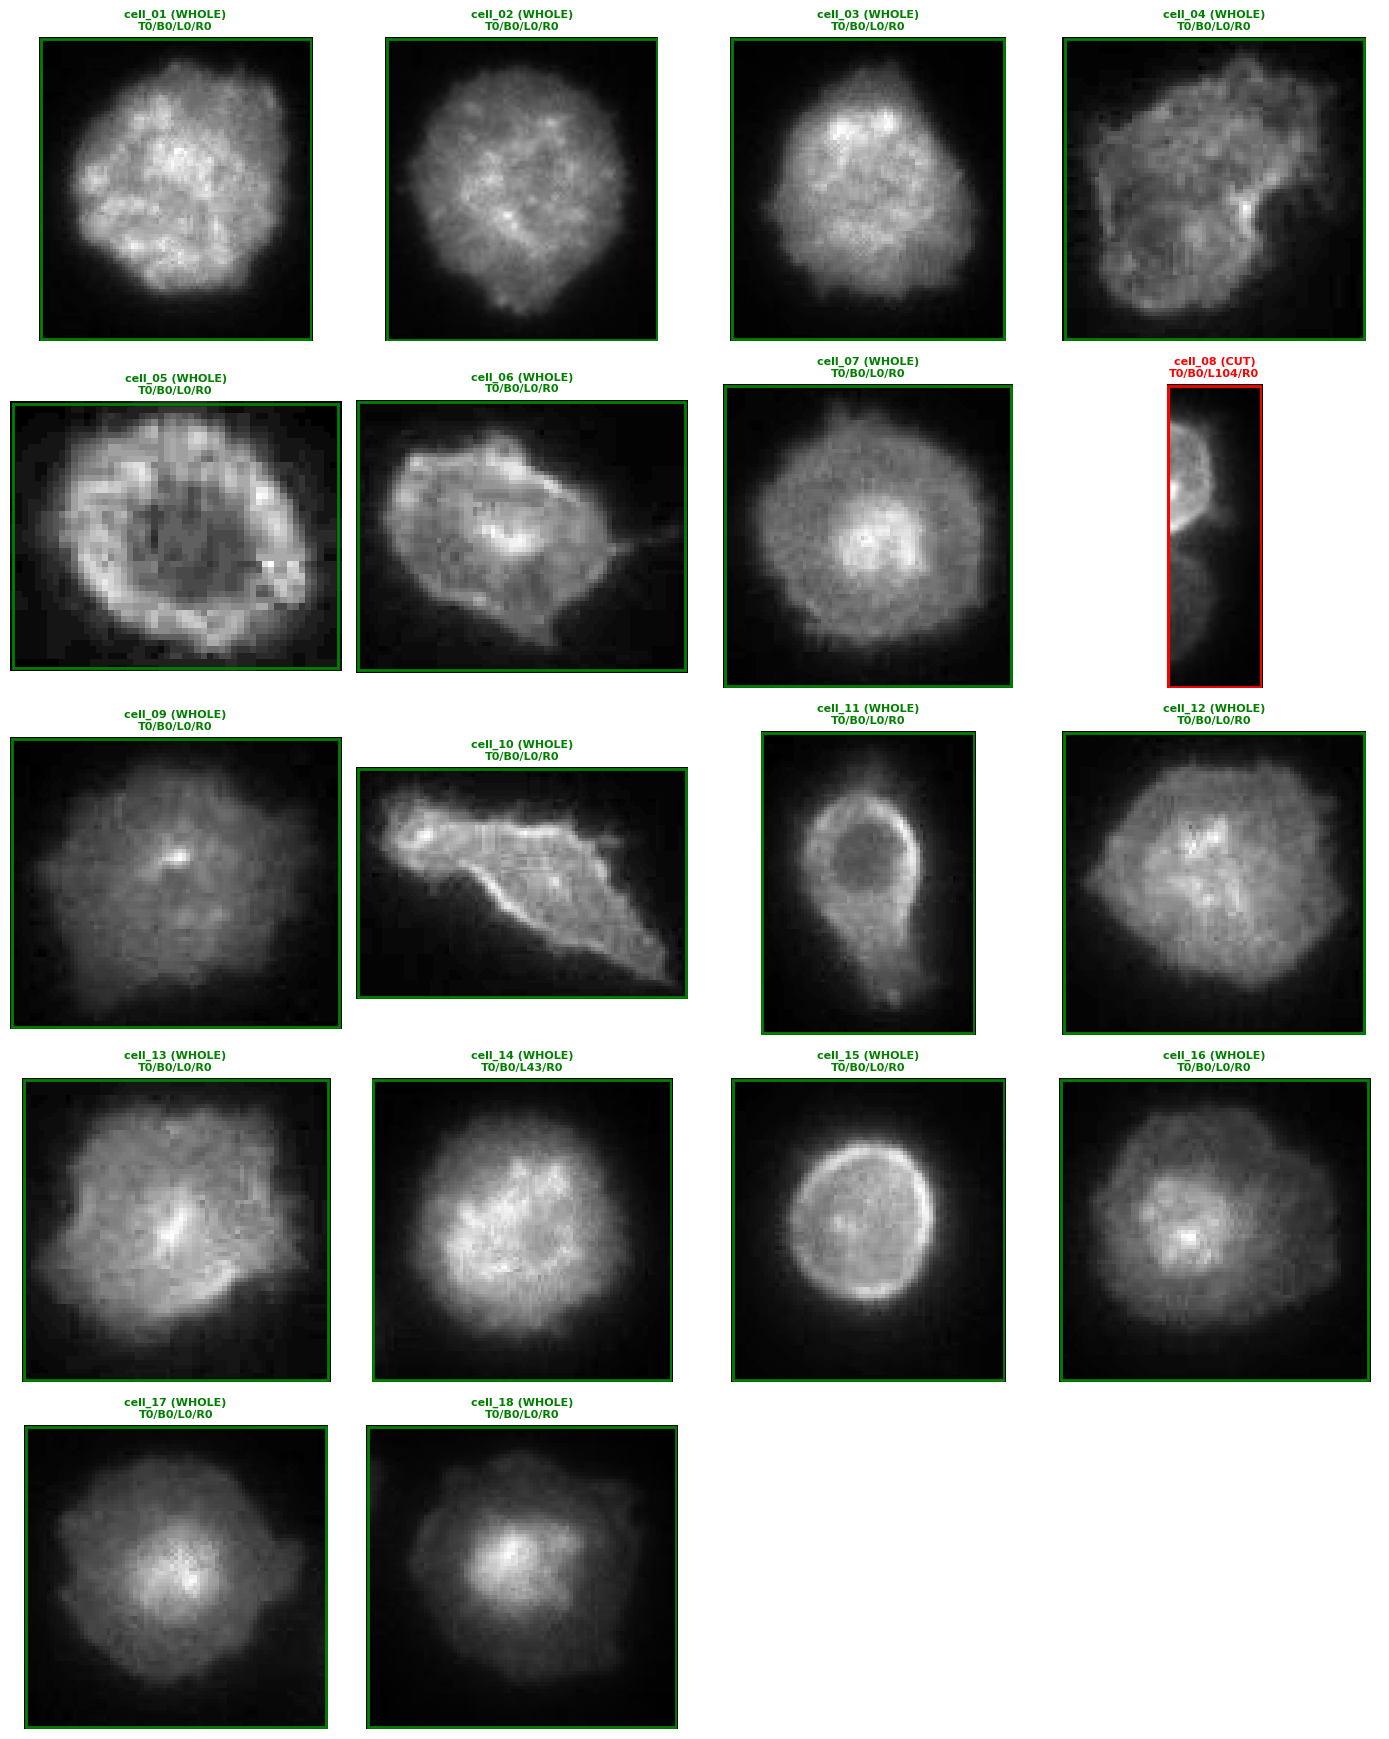

In [6]:
# Visualize each segmented image with ROI masks
import matplotlib.patches as patches
from pathlib import Path

def visualize_roi_masks(results, roi_dir, raw_crops_dir, max_display=10, consecutive_threshold=5):
    """Visualize ROI mask analysis results"""
    
    # Sort results by cell number (extracted from filename)
    def get_cell_number(result):
        filename_parts = result['filename'].replace('.tif', '').split('_')
        return int(filename_parts[-1])  # Extract number from cell_XX.tif
    
    sorted_results = sorted(results, key=get_cell_number)
    
    # Take first max_display results in order
    display_results = sorted_results[:max_display]
    
    # Create subplots with smaller figure size
    n_images = len(display_results)
    cols = 4  # More columns for smaller images
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if n_images > 1 else [axes]
    
    for i, result in enumerate(display_results):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        # Extract cell number from ROI filename (cell_01.tif -> 01)
        cell_num = result['filename'].replace('cell_', '').replace('.tif', '')
        
        # Find matching raw crop file (may have different naming convention)
        raw_crops_path = Path(raw_crops_dir)
        matching_files = list(raw_crops_path.glob(f"*cell_{cell_num}_*.tif"))
        
        if not matching_files:
            # Try simpler pattern - just cell_XX.tif
            matching_files = list(raw_crops_path.glob(f"cell_{cell_num}.tif"))
        
        if matching_files:
            raw_crop_path = matching_files[0]
            raw_crop = np.array(Image.open(raw_crop_path).convert('L'))
        else:
            print(f"⚠️ Could not find raw crop for {result['filename']}")
            continue
        
        # Display raw crop
        ax.imshow(raw_crop, cmap='gray')
        
        # Create colored border overlay for cut edges
        h, w = raw_crop.shape
        edge_pixels = result['edge_consecutive_pixels']
        is_cut = result['is_cut_off']
        
        # Draw thick border lines for cut edges
        if edge_pixels['top'] >= consecutive_threshold:
            ax.plot([0, w-1], [0, 0], color='red', linewidth=3, solid_capstyle='butt')
        if edge_pixels['bottom'] >= consecutive_threshold:
            ax.plot([0, w-1], [h-1, h-1], color='red', linewidth=3, solid_capstyle='butt')
        if edge_pixels['left'] >= consecutive_threshold:
            ax.plot([0, 0], [0, h-1], color='red', linewidth=3, solid_capstyle='butt')
        if edge_pixels['right'] >= consecutive_threshold:
            ax.plot([w-1, w-1], [0, h-1], color='red', linewidth=3, solid_capstyle='butt')
        
        # Add border frame (green for whole, red for cut)
        border_color = 'red' if is_cut else 'green'
        rect = patches.Rectangle((0, 0), w-1, h-1, linewidth=2, edgecolor=border_color, facecolor='none')
        ax.add_patch(rect)
        
        # Extract cell identifier from filename
        cell_id = result['filename'].replace('.tif', '')
        
        status = "CUT" if is_cut else "WHOLE"
        pixels_str = f"T{edge_pixels['top']}/B{edge_pixels['bottom']}/L{edge_pixels['left']}/R{edge_pixels['right']}"
        title = f"{cell_id} ({status})\n{pixels_str}"
        
        # Red title for cut cells
        title_color = 'red' if is_cut else 'green'
        
        ax.set_title(title, fontsize=8, color=title_color, fontweight='bold')
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(n_images, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show visualizations using global paths
print("\nShowing ROI mask analysis results:")
print("🔴 Red border/title = Cut cells (straight line of white pixels at border)")
print("🟢 Green border/title = Whole cells")
print(f"📏 Numbers show consecutive white pixels at each edge (threshold={CONSECUTIVE_THRESHOLD})")
print("━━━ Thick red lines = Detected cut edges")
print()

visualize_roi_masks(results, ROI_DIR, RAW_CROPS_DIR, max_display=30, consecutive_threshold=CONSECUTIVE_THRESHOLD)

In [7]:
# Save results to CSV using global path
df = pd.DataFrame(results)
output_path = f"{BASE_DIR}/raw_crops_quality_analysis.csv"
df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")

# Display summary statistics
print("\nQuality Summary:")
print(df['is_cut_off'].value_counts())
print("\nCell Count Summary:")
print(df['cell_count'].value_counts().sort_index())

✅ Results saved to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/1/raw_crops_quality_analysis.csv

Quality Summary:
is_cut_off
False    17
True      1
Name: count, dtype: int64

Cell Count Summary:
cell_count
1    18
Name: count, dtype: int64
